In [1]:
import stdpopsim
import numpy as np
import os
import tskit
import multiprocessing.pool as mp


In [2]:
class MsprimeSimulation():
    def __init__(self, seed, num_reps, sp_name, chrom, model_name, sims_root_path, sample_size=10, n_threads=6):
        # General configs
        self.seed = seed
        rng = np.random.default_rng(self.seed)
        self.engine = stdpopsim.get_engine("msprime")
        self.n_threads = n_threads
        # Simulation parameters
        self.sp_name = sp_name
        self.chrom = chrom
        self.model_name = model_name
        self.sample_size = sample_size
        # Path parameters
        self.sims_path = f"{sims_root_path}{self.sp_name}/{self.chrom}/{self.model_name}/"
        os.makedirs(self.sims_path, exist_ok=True) # ensuring that sims_path exists
        self.seed_array = rng.integers(1,2**31,num_reps)
        self.ts_paths = [f"{self.sims_path}/sim_{seed}.trees" for seed in self.seed_array]
        # Objects to be used in the simulation
        self.species = stdpopsim.get_species(self.sp_name)
        self.model = self.species.get_demographic_model(self.model_name)
        self.contig = self.species.get_contig(self.chrom, mutation_rate=self.model.mutation_rate)
        self.samples = {pop.name: self.sample_size for pop in self.model.populations}
        self.run()
    
    def run_sim(self, seed):
        tspath = f"{self.sims_path}/sim_{seed}.trees"
        if not os.path.exists(tspath):
            ts = self.engine.simulate(self.model, self.contig, self.samples, seed=seed)
            ts.dump(tspath)
        return tspath

    def run(self):
        with mp.ThreadPool(self.n_threads) as p:
            results = list(p.imap(self.run_sim, self.seed_array))
        assert results == self.ts_paths 

In [3]:
## CONSTANTS
seed = 11379
num_reps = 200
sp_name = "HomSap"
chrom = "chr13"
model_name ="OutOfAfrica_3G09"
sample_size=10
HomSap_chr13_OOA = MsprimeSimulation(seed, num_reps, sp_name, chrom, model_name, "data/raw/", sample_size, n_threads=6)


In [4]:
ts=tskit.load(HomSap_chr13_OOA.ts_paths[0])

In [5]:
list(ts.breakpoints())[0:3]

[0.0, 161.0, 336.0]

In [6]:
tree = next(ts.trees())

In [7]:
edges = ts.tables.edges

In [8]:
edges_idx = np.row_stack((edges.parent, edges.child))
edges_interval = np.row_stack((edges.left, edges.right))

In [9]:
left = 0
right = 6000

In [10]:
import torch
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv, pool, SAGEConv, models

In [11]:
class TreeSequenceData(Data):
    def __init__(self, x=None, edge_index=None, edge_attr=None, y=None, pos=None, edge_interval=None, sequence_length=None):
        super().__init__(x, edge_index, edge_attr, y, pos)
        self.edge_interval = edge_interval
        self.sequence_length = sequence_length
    def get_subgraph(self, left, right):
        # selecting edges that overlap with the interval [left, right)
        overlap = np.logical_and(self.edge_interval[0,:] < right, self.edge_interval[1,:] >= left)
        return self.edge_index[:,overlap]

In [12]:
def convert_tseq (ts):
    edges = ts.tables.edges
    edge_idx = torch.LongTensor(np.row_stack((edges.parent, edges.child)))
    edge_interval = torch.FloatTensor(np.row_stack((edges.left, edges.right)))
    node_features = []
    assert np.all(np.diff(np.unique(edges_idx.flatten())) == 1) # there are no gaps in node ids
    for node in ts.nodes():
        node_features.append([node.time, node.is_sample()])
    node_features = torch.FloatTensor(node_features)
    return edge_idx, edge_interval, node_features, ts.sequence_length


In [17]:
eix, ei, nf, sq = convert_tseq(ts)
a=TreeSequenceData(edge_index=eix, edge_interval=ei, x = nf, sequence_length=sq)

In [18]:
a.y

In [20]:
a.get_subgraph(100,500).flatten()

/var/folders/1p/gjszg87s3glbwxkd5_x2j9x80000gn/T/ipykernel_23603/4112283796.py:9: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1675740388473/work/aten/src/ATen/native/IndexingUtils.h:28.)
  return self.edge_index[:,overlap]


tensor([   331,    331,    413,    413,    447,    447,    618,    618,   1342,
          1342,   2256,   2256,   3850,   3850,   5850,   5850,   7023,   7023,
          9010,   9010,   9241,   9241,  10488,  10488,  10611,  10611,  11325,
         11325,  11505,  11505,  11696,  11696,  12466,  12466,  12566,  12566,
         13527,  13527,  14050,  14050,  15073,  15073,  15532,  15532,  15985,
         15985,  17173,  17173,  18748,  18748,  20059,  20059,  21161,  21161,
         21338,  21338,  21942,  21942,  24567,  24567,  24589,  24589,  25004,
         25004,  25272,  25272,  25426,  25426,  29085,  29085,  29919,  29919,
         29956,  29956,  31044,  31044,  33675,  33675,  36058,  36058,  40152,
         40152,  40426,  40426,  42255,  42255,  45083,  45083,  47084,  47084,
         47491,  47491,  51396,  51396,  52264,  52264,  52423,  52423,  53254,
         53254,  60174,  60174,  62604,  62604,  68759,  68759,  76629,  76629,
         86199,  86199,  89920,  89920, 

In [89]:
class TreeSequencesDataset(Dataset):
    def __init__(self, root, raw_root, transform=None, pre_transform=None, pre_filter=None, seeds=None, y_func=None, y_name=None):
        self.seeds = seeds
        self.raw_root = raw_root
        if y_func is None:
            assert y_name is None
            def _windowed_div_from_ts(ts, num_windows=1):
                windows = np.linspace(0, ts.sequence_length, num_windows+1)
                div = ts.diversity(windows=windows, mode="branch")
                return torch.FloatTensor(div)
            self.y_func = _windowed_div_from_ts
            self.y_name = "win-div"
        else:
            assert y_name is not None
            self.y_func = y_func
            self.y_name = y_name
        super().__init__(root, transform, pre_transform, pre_filter)

    @property
    def raw_file_names(self):
        return [f'{self.raw_root}sim_{s}.trees' for s in self.seeds]

    @property
    def processed_file_names(self):
        return [f'tseq_{i}.pt' for i in range(len(self.seeds))]

    def download(self):
        pass

    def process(self):
        for raw_file_name, i in zip(self.raw_file_names, range(len(self.seeds))):
            ts = tskit.load(raw_file_name)
            edge_idx, edge_int, node_features, seq_len = convert_tseq(ts)
            data = TreeSequenceData(x=node_features, edge_index = edge_idx, edge_interval=edge_int, sequence_length=seq_len)
            torch.save(data, os.path.join(self.processed_dir, f'tseq_{i}.pt'))
        self.process_y()
    
    def process_y(self, y_func=None, y_name = None, **kwargs):
        if y_func is None:
            assert y_name is None
            y_func = self.y_func
            y_name = self.y_name
        else:
            self.y_func = y_func
            self.y_name = y_name
        for raw_file_name, i in zip(self.raw_file_names, range(len(self.seeds))):
            ts = tskit.load(raw_file_name)
            y = y_func(ts, **kwargs)
            torch.save(y, os.path.join(self.processed_dir, f'y_{y_name}_{i}.pt'))

    def len(self):
        return len(self.processed_file_names)
    
    def get(self, idx):
        data = torch.load(os.path.join(self.processed_dir, f'tseq_{idx}.pt'))
        y = torch.load( os.path.join(self.processed_dir, f'y_{self.y_name}_{idx}.pt'))
        data.y = y
        return data

In [90]:
dataset = TreeSequencesDataset("data/", HomSap_chr13_OOA.sims_path,seeds=HomSap_chr13_OOA.seed_array)

In [91]:
dataset.process_y()

In [92]:
dataset[0].y

tensor([30933.8730])

In [93]:
class BiGCNEncoder(torch.nn.Module):
    """
    A bidirectional GCN that takes a TreeSequenceData object as input and returns a vector of node embeddings.
    Node embeddings are updated by a GCN layer applied to edges that overlap with a window at a time, going both forwards and backwards.
    Forward and backward embeddings are summed to get the final embedding.
    TODO: 
        - add a way to specify sequence breaks
        - remove manual seed
    """
    def __init__(self, in_features, out_features=4):
        super(BiGCNEncoder, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        torch.manual_seed(12345)
        # Layers to do the Graph convolutions (return vector of node embeddings with num_hidden features)
        self.conv_f = SAGEConv(self.in_features, self.out_features)
        self.conv_b = SAGEConv(self.in_features, self.out_features)

    def forward(self, data):
        breaks = [0, data.sequence_length]
        x_f = data.x.clone()
        x_b = data.x.clone()
        #print(x_f.shape, x_b.shape)
        for i in range(len(breaks)-1):
            left = breaks[i]
            right = breaks[i+1]
            #print(left,right)
            subgraph_edge = data.get_subgraph(left, right)
            x_f = self.conv_f(x_f, subgraph_edge)
        for i in range(len(breaks)-1, 0, -1):
            left = breaks[i-1]
            right = breaks[i]
            #print(left, right)
            subgraph_edge = data.get_subgraph(left, right)
            x_b = self.conv_b(x_b, subgraph_edge)
        x = torch.add(x_f,x_b)
        #print(x_f.shape, x_b.shape)
        return x


In [136]:
def windowed_sum_pooling(x, data, breaks=None):
    """
    Pooling function that pools the embeddings of nodes in a window by summing them.
    Returns a tensor of shape (num_windows, num_encoder_out_features)
    """
    if breaks is None:
        breaks = [0, data.sequence_length]
    x_pooled = []
    for i in range(len(breaks)-1):
        left = breaks[i]
        right = breaks[i+1]
        nodes_in_window = data.get_subgraph(left, right).flatten()
        x_pooled.append(torch.sum(x[nodes_in_window], dim=0))
    x_pooled = torch.stack(x_pooled)
    return x_pooled

In [137]:
class BiGCNModel(torch.nn.Module):
    def __init__(self, num_encoder_in_features=None, num_encoder_out_features=32, mlp_channels=None, pooling="windowed_sum", breaks=None):
        super(BiGCNModel, self).__init__()
        self.breaks = breaks
        self.encoder = BiGCNEncoder(num_encoder_in_features, num_encoder_out_features)
        #self.mlp = models.MLP(mlp_channels)
        self.lin1 = Linear(num_encoder_out_features,32)
        self.lin2 = Linear(32,1)
        #if pooling == "windowed_sum":
        self.pooling = windowed_sum_pooling

    def forward(self, data):
        # node embeddings num_nodes x num_encoder_out_features
        x = self.encoder(data)
        # pooled embeddings num_windows x num_encoder_out_features
        h = self.pooling(x, data)
        # final output num_windows x 1
        #print(h.shape)
        h = F.relu(self.lin1(h))
        out = F.relu(self.lin2(h))
        return out

In [140]:
dataset.len()

200

In [141]:
from torch.utils.data import random_split


train_set, valid_set, test_set = random_split(dataset,[120, 40, 40])

trainloader = DataLoader(train_set, batch_size=1, shuffle=True)
validloader = DataLoader(valid_set, batch_size=1, shuffle=True)
testloader = DataLoader(test_set, batch_size=1, shuffle=True)

In [142]:
model = BiGCNModel(num_encoder_in_features=dataset.num_features)
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
num_epochs=10
device = torch.device("cpu")
criterion = torch.nn.L1Loss()

for epoch in range(num_epochs):
    epoch_loss = 0
    model.train()
    num_batches = 0
    for batch in trainloader:
        num_batches+=1
        batch.to(device)
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output,batch.y.unsqueeze(1).type(torch.FloatTensor))
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
    
    train_avg_loss = epoch_loss / num_batches
    val_loss = 0
    model.eval()
    num_batches = 0
    for batch in validloader:
        num_batches+=1
        batch.to(device)
        output = model(batch)
        loss = criterion(output,batch.y.unsqueeze(1).type(torch.FloatTensor))
        val_loss += loss.item()
    val_avg_loss = val_loss/num_batches
    
    
    print(f"Epochs: {epoch} | epoch avg. loss: {train_avg_loss:.2f} | validation avg. loss: {val_avg_loss:.2f}")

/var/folders/1p/gjszg87s3glbwxkd5_x2j9x80000gn/T/ipykernel_23603/4112283796.py:9: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1675740388473/work/aten/src/ATen/native/IndexingUtils.h:28.)
  return self.edge_index[:,overlap]


Epochs: 0 | epoch avg. loss: 31040.55 | validation avg. loss: 31033.22
Epochs: 1 | epoch avg. loss: 31040.55 | validation avg. loss: 31033.22


KeyboardInterrupt: 

In [133]:
model.eval()

BiGCNModel(
  (encoder): BiGCNEncoder(
    (conv_f): SAGEConv(2, 4, aggr=mean)
    (conv_b): SAGEConv(2, 4, aggr=mean)
  )
  (lin1): Linear(in_features=4, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=1, bias=True)
)

In [134]:
model.eval()
predictions = []
real = []

for batch in testloader:
    
    output = model(batch.to(device))
    predictions.append(output.detach().cpu().numpy())
    real.append(batch.y.detach().cpu().numpy())

predictions = np.concatenate(predictions)
real = np.concatenate(real)

/var/folders/1p/gjszg87s3glbwxkd5_x2j9x80000gn/T/ipykernel_23603/4112283796.py:9: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1675740388473/work/aten/src/ATen/native/IndexingUtils.h:28.)
  return self.edge_index[:,overlap]


Text(0.5, 0, 'Observed diversity')

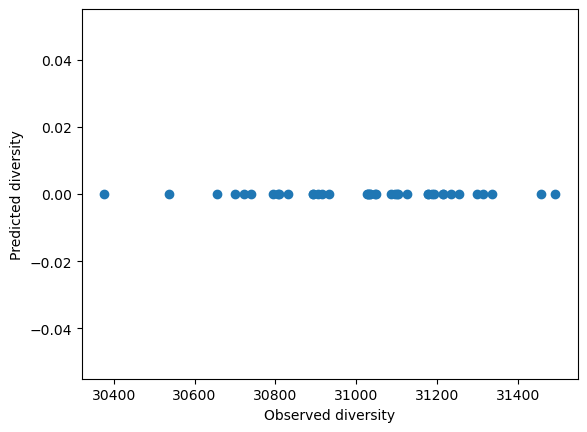

In [135]:
import matplotlib.pyplot as plt


plt.scatter(real,predictions)
plt.ylabel('Predicted diversity')
plt.xlabel('Observed diversity')